In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio
from parameters.parameters import Parameters as params
## analysis imports
from analysis.dately_analysis import DatelyAnalysis as dately_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.DAILY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.DAILY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.DAILY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
# portfolios.append(portfolio)
# portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)

In [5]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [6]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [7]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [8]:
analysis = []
parameters = params.parameters()
indexer = list(parameters[0].keys()) + ['portfolio']
indexer
for portfolio in tqdm(portfolios):
    portfolio.db.connect()
    for parameter in tqdm(parameters):
        try:
            trade = portfolio.db.query("trades",parameter)
            if trade.index.size > 0:
                indexer = list(parameters[0].keys()) + ['portfolio']
                positions = int(portfolio.pricer_class.positions / 10) if portfolio.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  portfolio.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = weekly_analysis if pricer_timeframe == "week" else dately_analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["portfolio"] = portfolio.name
                    analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    portfolio.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:04<00:00, 364.07s/it]


In [9]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,portfolio,pv,beta,rrr,sharpe
9,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
11,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields10,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
10,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields2,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
7,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields2,dsw_n_n_b_r,9.317782,-0.212735,1.013569,-39.099052
8,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields10,dsw_n_n_b_r,9.317782,-0.212735,1.013569,-39.099052
6,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields,dsw_n_n_b_r,9.317782,-0.212735,1.013569,-39.099052
1,True,True,False,False,False,1.15,5,1,flat,0.5,tyields2,dsw_n_n_b_r,5.884008,-0.213543,1.013625,-22.871047
0,True,True,False,False,False,1.15,5,1,flat,0.5,tyields,dsw_n_n_b_r,5.884008,-0.213543,1.013625,-22.871047
2,True,True,False,False,False,1.15,5,1,flat,0.5,tyields10,dsw_n_n_b_r,5.884008,-0.213543,1.013625,-22.871047
5,True,True,False,False,False,1.15,5,1,flat,1.0,tyields10,dsw_n_n_b_r,5.463013,-0.145571,1.009304,-30.658253


In [10]:
a[a["risk"]=="none"].sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,pv,beta,rrr,sharpe
0,dsw_n_n_b_r,True,True,False,False,False,1.15,5,1,none,0.5,tyields,4.15008,-0.228277,1.014618,-13.799151


In [11]:
top = a[a["risk"]=="none"].sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["portfolio"])
parameter = top[[x for x in indexer if x != "portfolio"]].to_dict()
parameter
db.connect()
analysis = db.query("trades",parameter)
db.disconnect()

In [12]:
anas = dately_analysis
naming = "date"
positions = int(int(analysis["position"].max())/5)
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [13]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,TPR,0.267478,1.0,0.997321,0,Consumer Discretionary,"Tapestry, Inc."
1,2001,2001-01-03,PXD,0.215891,1.0,0.955616,0,Energy,Pioneer Natural Resources
2,2001,2001-01-04,ISRG,0.314286,1.0,0.976071,0,Health Care,Intuitive Surgical
3,2001,2001-01-05,BBY,0.359261,1.0,0.940411,0,Consumer Discretionary,Best Buy
4,2001,2001-01-08,BBY,0.395844,1.0,1.071619,0,Consumer Discretionary,Best Buy
...,...,...,...,...,...,...,...,...,...
298981,2013,2013-06-28,CB,0.015729,1.0,1.003241,99,Financials,Chubb Limited
298982,2013,2013-07-01,UAA,0.004019,1.0,0.999001,99,Consumer Discretionary,Under Armour (Class A)
298983,2013,2013-07-02,JNJ,0.003117,1.0,1.002426,99,Health Care,Johnson & Johnson
298984,2013,2013-07-03,EOG,0.016609,1.0,1.016066,99,Energy,EOG Resources


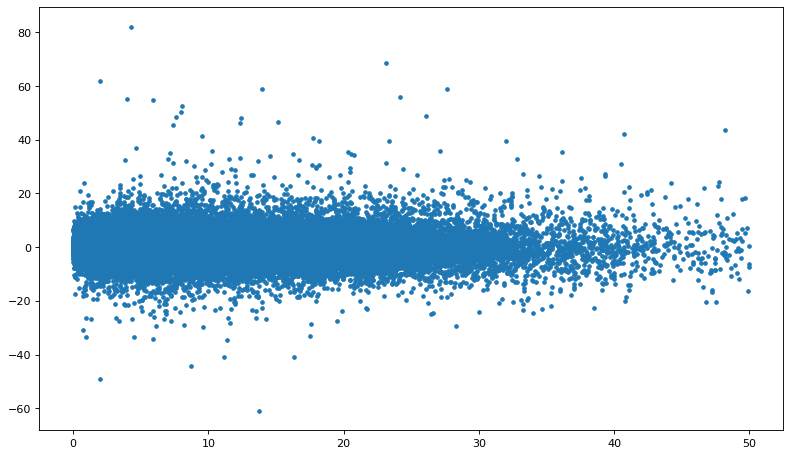

In [14]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [15]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,TPR,0.267478,1.0,0.997321,0,Consumer Discretionary,"Tapestry, Inc."
3142,2001,2001-01-02,PXD,0.256983,1.0,0.953999,1,Energy,Pioneer Natural Resources
6284,2001,2001-01-02,DVA,0.241097,1.0,1.097758,2,Health Care,DaVita Inc.
9423,2001,2001-01-02,MAS,0.238614,1.0,1.015472,3,Industrials,Masco
12562,2001,2001-01-02,WAB,0.217872,1.0,1.000000,4,Industrials,Wabtec
15700,2001,2001-01-02,HUM,0.204590,1.0,0.966533,5,Health Care,Humana
18838,2001,2001-01-02,GPC,0.198167,1.0,1.023503,6,Consumer Discretionary,Genuine Parts Company
21972,2001,2001-01-02,PAYX,0.198026,1.0,1.064347,7,Information Technology,Paychex
25106,2001,2001-01-02,HES,0.197509,1.0,0.946714,8,Energy,Hess Corporation
28238,2001,2001-01-02,MOS,0.192802,1.0,0.976508,9,Materials,The Mosaic Company


In [16]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
17596,2008,2008-07-21,UAL,0.231193,1.0,1.685371,5,Industrials,United Airlines Holdings
36583,2009,2009-05-07,FITB,0.276241,1.0,1.588103,11,Financials,Fifth Third Bank
34972,2002,2002-11-27,SEE,0.241964,1.0,1.560458,11,Materials,Sealed Air
5218,2009,2009-04-08,TXT,0.260532,1.0,1.488474,1,Industrials,Textron
10864,2006,2006-09-27,ALGN,0.124183,1.0,1.482051,3,Health Care,Align Technology
8222,2008,2008-09-18,ZION,0.151709,1.0,1.467908,2,Financials,Zions Bancorporation
55964,2012,2012-01-24,ILMN,0.123657,1.0,1.463447,17,Health Care,Illumina
2060,2009,2009-03-17,AIG,0.481928,1.0,1.437500,0,Financials,American International Group
1991,2008,2008-12-04,LNC,0.407618,1.0,1.421785,0,Financials,Lincoln Financial
15773,2001,2001-04-18,AKAM,0.320117,1.0,1.393805,5,Information Technology,Akamai


In [17]:
ledger["actual_returns"].mean()

1.0005160941183475

In [18]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.502317834279866

In [19]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [20]:
portfolio

position,year,date,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,2001,2001-01-02,0.997321,0.953999,1.097758,1.015472,1.000000,0.966533,1.023503,1.064347,...,1.002807,1.000779,1.043159,0.957263,1.031205,1.250806,0.965024,1.039440,0.972785,1.039964
1,2001,2001-01-03,0.955616,0.959325,1.016889,1.003571,1.007037,0.987646,1.054932,1.016889,...,0.993807,0.991472,0.972604,1.004760,0.994433,0.975020,0.816619,1.008696,1.095320,1.018155
2,2001,2001-01-04,0.976071,0.934187,1.039022,1.039601,0.916481,0.956560,0.966064,0.961920,...,0.960864,0.992519,0.996667,0.992439,1.005962,0.984828,0.978204,0.982143,0.966184,0.996873
3,2001,2001-01-05,0.940411,0.906977,1.000000,1.095444,1.085776,1.002070,0.967742,0.984609,...,0.986545,0.993694,0.975536,0.998400,0.955941,0.971938,0.980831,0.991580,0.998103,1.024486
4,2001,2001-01-08,1.071619,1.160256,0.982875,1.019936,0.913223,1.000000,1.027737,1.041333,...,1.027600,1.009321,0.985110,0.941765,1.023270,1.012683,0.985664,0.994419,0.978912,0.973949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,2013,2013-06-28,0.993532,0.995813,0.956066,1.019107,0.947756,1.016081,1.009903,1.091459,...,1.004190,1.022912,1.010593,1.003309,1.000000,1.027594,1.011595,0.988141,1.004331,1.003241
3138,2013,2013-07-01,0.953125,0.985245,0.993709,1.007352,1.002803,0.985440,1.006474,1.008214,...,0.992853,0.995443,0.994021,0.988678,0.996702,1.011132,0.991200,0.997999,1.000765,0.999001
3139,2013,2013-07-02,0.978102,1.015027,0.994127,0.999766,1.005782,0.998417,1.012861,1.000160,...,1.043286,0.998957,1.001096,0.996491,0.992874,1.008541,0.994571,1.005460,0.991743,1.002426
3140,2013,2013-07-03,1.020293,1.023326,1.042086,0.994282,1.009421,1.036585,1.025099,1.007792,...,1.004304,1.013747,1.011164,0.982953,1.016251,1.013366,1.007204,1.019253,1.015736,1.016066


In [21]:
positions = 10

In [22]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [23]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,year,date,pv,daily_returns,adjclose,bench
3132,2.087241,0.611312,0.905094,3.672662,22.358542,6.495551,1.088574,0.178075,1.104828,1.264764,2013,2013-06-21,3.976664,0.989594,1592.430054,1.240916
3133,2.102491,0.591034,0.936837,3.751790,22.555963,6.672389,1.109154,0.177074,1.139248,1.241893,2013,2013-06-24,4.027787,1.009316,1573.089966,1.225845
3134,2.120103,0.590959,0.942378,3.732389,23.287269,6.765690,1.120700,0.177957,1.174461,1.240755,2013,2013-06-25,4.115266,1.010079,1588.030029,1.237487
3135,2.134789,0.644605,0.953348,3.745381,24.183691,6.819629,1.119630,0.183560,1.157915,1.222773,2013,2013-06-26,4.216532,1.016124,1603.260010,1.249355
3136,2.131656,0.644156,0.963444,3.695968,23.765319,6.764827,1.114612,0.183619,1.160511,1.209805,2013,2013-06-27,4.163392,0.995737,1613.199951,1.257101
3137,2.117868,0.641459,0.921116,3.766588,22.523716,6.873610,1.125650,0.200412,1.172454,1.227793,2013,2013-06-28,4.057067,1.005488,1606.280029,1.251709
3138,2.018593,0.631994,0.915322,3.794279,22.586852,6.773530,1.132937,0.202058,1.184526,1.216157,2013,2013-07-01,4.045625,0.994318,1614.959961,1.258472
3139,1.974390,0.641491,0.909946,3.793389,22.717440,6.762809,1.147508,0.202091,1.190541,1.206310,2013,2013-07-02,4.054591,1.000122,1614.079956,1.257787
3140,2.014456,0.656454,0.948242,3.771697,22.931467,7.010229,1.176309,0.203666,1.241867,1.266467,2013,2013-07-03,4.122085,1.025187,1615.410034,1.258823
3141,1.945578,0.654306,0.960244,4.028172,23.046866,6.951743,1.180557,0.204467,1.250047,1.278821,2013,2013-07-05,4.150080,1.006377,1619.090000,1.261691


In [34]:
cumulative["previous_day"] = cumulative["daily_returns"].shift(1)
cumulative["base"] = [min(row[1]["previous_day"],1) for row in cumulative.iterrows()]
cumulative["real_return"] = cumulative["base"] * cumulative["daily_returns"]
cumulative["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cumulative.iterrows()]
cumulative["running_cash"] = cumulative["cash"].cumsum()

In [35]:
cumulative["cash"].sum()

1732.5734296677856

In [36]:
cumulative[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.004215,NaN,NaN,0.000000,0.000000
1,0.994378,1.000000,0.994378,0.000000,0.000000
2,0.973729,0.994378,0.968255,0.000000,0.000000
3,0.993957,0.973729,0.967845,0.000000,0.000000
4,1.036434,0.993957,1.030170,3.017043,3.017043
...,...,...,...,...,...
3137,1.005488,0.995737,1.001202,0.120161,1729.417094
3138,0.994318,1.000000,0.994318,0.000000,1729.417094
3139,1.000122,0.994318,0.994440,0.000000,1729.417094
3140,1.025187,1.000000,1.025187,2.518655,1731.935749


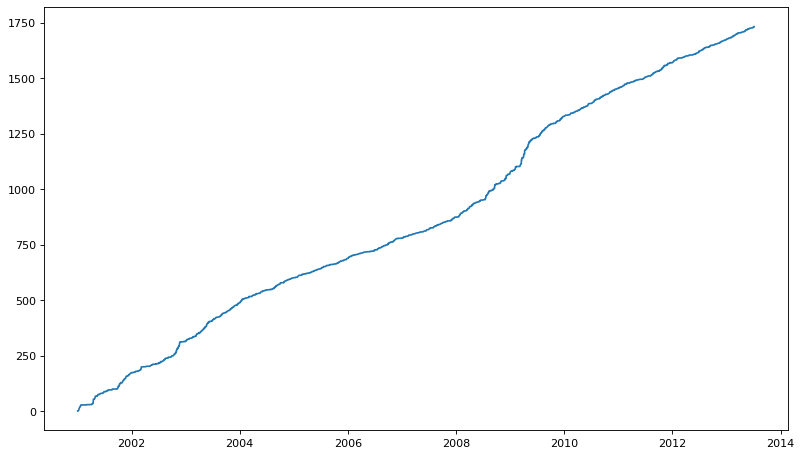

In [38]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["running_cash"])

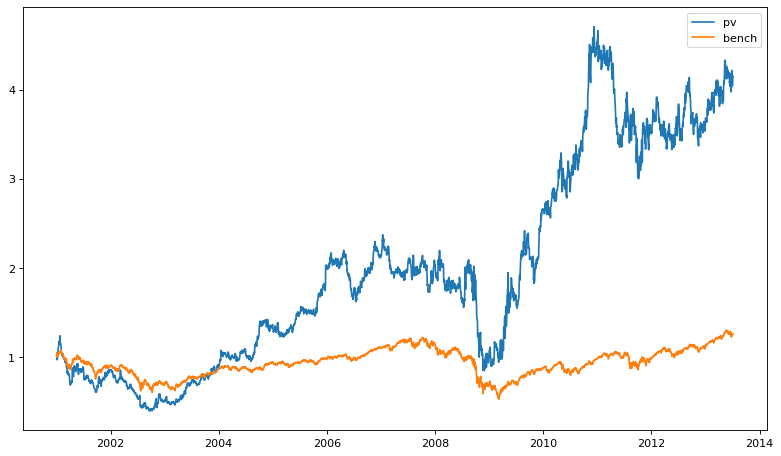

In [26]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [27]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,year,date,pv,daily_returns,adjclose,bench,previous_day,base,real_return,cash
3122,2.063085,0.680584,0.972025,3.586475,23.780185,7.038574,1.176989,0.179062,1.078003,1.340447,2013,2013-06-07,4.189543,1.003352,1643.380005,1.280619,1.020489,1.000000,1.003352,0.335172
3123,2.022837,0.674805,0.934075,3.631832,23.462861,6.999802,1.131840,0.180394,1.062197,1.325956,2013,2013-06-10,4.142660,0.987035,1642.810059,1.280175,1.003352,1.000000,0.987035,0.000000
3124,1.964526,0.673779,0.942141,3.540824,22.995223,6.967974,1.126123,0.181281,1.069486,1.307933,2013,2013-06-11,4.076929,0.992189,1626.130005,1.267177,0.987035,0.987035,0.979326,0.000000
3125,1.993998,0.674868,0.938830,3.502785,23.149912,6.888070,1.107193,0.187392,1.097007,1.378436,2013,2013-06-12,4.091849,1.009416,1612.520020,1.256571,0.992189,0.992189,1.001531,0.153115
3126,1.986310,0.645043,0.918597,3.510709,22.764793,6.826297,1.110024,0.184801,1.067276,1.362420,2013,2013-06-13,4.037627,0.985707,1636.359985,1.275149,1.009416,1.000000,0.985707,0.000000
3127,1.955554,0.648853,0.953152,3.676614,23.408299,6.862974,1.110607,0.188112,1.074595,1.376657,2013,2013-06-14,4.125542,1.014469,1626.729980,1.267644,0.985707,0.985707,0.999969,0.000000
3128,1.986310,0.649071,0.956653,3.818236,23.681023,6.942885,1.120099,0.187305,1.089388,1.364213,2013,2013-06-17,4.179518,1.009053,1639.040039,1.277237,1.014469,1.000000,1.009053,0.905330
3129,2.018091,0.643776,0.940313,3.751725,23.298597,6.889254,1.120099,0.185637,1.078188,1.342504,2013,2013-06-18,4.126818,0.991437,1651.810059,1.287188,1.009053,1.000000,0.991437,0.000000
3130,1.969063,0.623730,0.903445,3.807536,22.896559,6.584536,1.086405,0.181010,1.112139,1.324971,2013,2013-06-19,4.048939,0.982217,1628.930054,1.269359,0.991437,0.991437,0.973806,0.000000
3131,2.022163,0.627255,0.913781,3.792719,23.080418,6.488580,1.086405,0.178931,1.106804,1.310491,2013,2013-06-20,4.060755,1.000641,1588.189941,1.237612,0.982217,0.982217,0.982847,0.000000


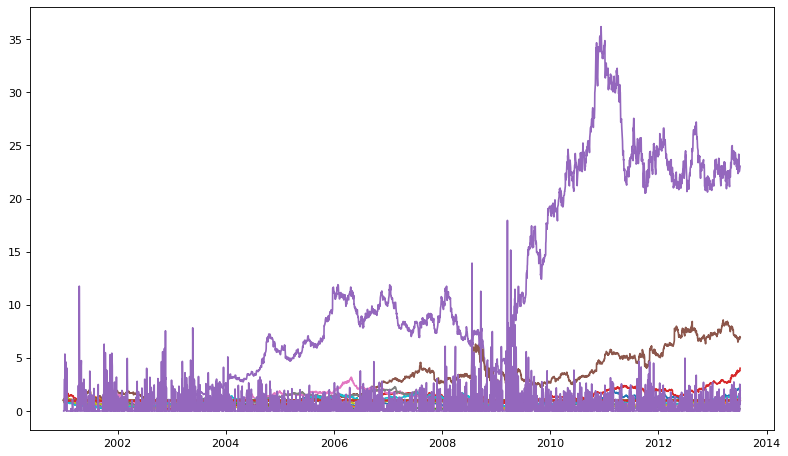

In [28]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [29]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Materials,2006.854742,0.067401,1.0,1.000859,49.583414
Real Estate,2006.780677,0.064448,1.0,1.000845,52.905476
Consumer Discretionary,2006.896765,0.075660,1.0,1.000841,44.949603
Consumer Staples,2006.522412,0.049000,1.0,1.000593,52.536108
Financials,2007.155011,0.070513,1.0,1.000524,52.308442
Industrials,2006.689600,0.067702,1.0,1.000499,51.423354
Utilities,2006.249548,0.048035,1.0,1.000489,56.598399
Health Care,2006.478191,0.068804,1.0,1.000441,45.441286
Energy,2006.749930,0.065454,1.0,1.000229,46.667733


In [30]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                      
2008 2008-09-18 RF     Regions Financial Corporation      0.042648   
     2008-07-21 UAL    United Airlines Holdings           0.231193   
2013 2013-04-18 VRTX   Vertex Pharmaceuticals             0.020261   
2009 2009-05-07 FITB   Fifth Third Bank                   0.276241   
2008 2008-07-21 AAL    American Airlines Group            0.139373   
2002 2002-11-27 SEE    Sealed Air                         0.241964   
2012 2012-05-04 VRTX   Vertex Pharmaceuticals             0.040147   
2008 2008-02-22 TTWO   Take-Two Interactive               0.059377   
2001 2001-04-02 SO     Southern Company                   0.080365   
2008 2008-12-03 DXCM   Dexcom                             0.080000   
2009 2009-04-08 TXT    Textron                            0.260532   
2003 2003-08-20 ZBRA   Zebra Technologies                 0.075791   
2006 2006-09-27 ALGN   Align Technology                   0.124183   
2008 2008-09-18 ZION   Zions Bancorporation               0.151709   
2012 2012-01-24 ILMN   Illumina                           0.123657   
2002 2002-11-20 AKAM   Akamai                             0.073770   
2009 2009-03-17 AIG    American International Group       0.481928   
2008 2008-12-04 LNC    Lincoln Financial                  0.407618   
2003 2003-05-16 REGN   Regeneron                          0.095172   
2008 2008-12-04 PFG    Principal Financial Group          0.177010   
2001 2001-04-18 FFIV   F5, Inc.                           0.181818   
                AKAM   Akamai                             0.320117   
2002 2002-10-30 AES    AES Corporation                    0.233871   
2011 2011-02-09 IPGP   IPG Photonics                      0.046670   
2001 2001-04-30 BKNG   Booking Holdings                   0.271429   
2003 2003-04-22 AKAM   Akamai                             0.102410   
2009 2009-04-08 FITB   Fifth Third Bank                   0.203390   
     2009-05-04 MGM    MGM Resorts                        0.361323   
2003 2003-10-29 AKAM   Akamai                             0.071786   
2009 2009-02-05 SWKS   Skyworks Solutions                 0.162933   

                                                      dately_delta_sign  \
year date       ticker Security                                           
2008 2008-09-18 RF     Regions Financial Corporation                1.0   
     2008-07-21 UAL    United Airlines Holdings                     1.0   
2013 2013-04-18 VRTX   Vertex Pharmaceuticals                       1.0   
2009 2009-05-07 FITB   Fifth Third Bank                             1.0   
2008 2008-07-21 AAL    American Airlines Group                      1.0   
2002 2002-11-27 SEE    Sealed Air                                   1.0   
2012 2012-05-04 VRTX   Vertex Pharmaceuticals                       1.0   
2008 2008-02-22 TTWO   Take-Two Interactive                         1.0   
2001 2001-04-02 SO     Southern Company                             1.0   
2008 2008-12-03 DXCM   Dexcom                                       1.0   
2009 2009-04-08 TXT    Textron                                      1.0   
2003 2003-08-20 ZBRA   Zebra Technologies                           1.0   
2006 2006-09-27 ALGN   Align Technology                             1.0   
2008 2008-09-18 ZION   Zions Bancorporation                         1.0   
2012 2012-01-24 ILMN   Illumina                                     1.0   
2002 2002-11-20 AKAM   Akamai                                       1.0   
2009 2009-03-17 AIG    American International Group                 1.0   
2008 2008-12-04 LNC    Lincoln Financial                            1.0   
2003 2003-05-16 REGN   Regeneron                                    1.0   
2008 2008-12-04 PFG    Principal Financial Group                    1.0   
2001 2001-04-18 FFIV   F5, Inc.                                     1.0   
                AKAM   Akamai                                       1.0   
2002 2002-10-

In [31]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.048729,1.057248,0.981071,0.969437,1.063814,1.008556,1.030495,1.117114,1.010773,1.038425,0.979270
1,4004001,2252-06-29 23:17:13.297436672,1.081376,1.080781,0.947236,0.931061,1.056160,0.956237,1.045940,1.085925,1.024188,1.023986,0.949891
2,8012006001,2159-09-27 04:21:44.589074432,1.030595,1.055328,0.916751,0.956811,1.016409,0.935494,1.028892,1.045547,0.998357,0.968106,0.949891
3,16032024008001,1970-01-01 00:00:00.000000000,1.009429,1.039758,0.923741,0.956811,1.007367,0.905317,1.019560,1.057308,0.993627,0.966325,0.949891
4,32080080040010001,1970-01-01 00:00:00.000000000,1.013125,1.056054,0.920878,0.912890,0.997067,0.932890,1.014216,1.082562,0.979175,0.983161,0.949891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0,1970-01-01 00:00:00.000000000,1.362142,4.549562,3.125749,3.177638,1.810428,3.794575,2.357786,1.579694,7.425906,2.485057,1.907273
3138,0,1970-01-01 00:00:00.000000000,1.365493,4.536370,3.141746,3.177638,1.811890,3.769768,2.351615,1.560843,7.425906,2.505883,1.903984
3139,0,1970-01-01 00:00:00.000000000,1.368555,4.550683,3.126253,3.177638,1.814554,3.782654,2.343595,1.567887,7.425906,2.494388,1.893744
3140,0,1970-01-01 00:00:00.000000000,1.382017,4.614495,3.145972,3.228689,1.861613,3.856604,2.375139,1.591736,7.425906,2.486597,1.878385
